#### Mean Reversion Strategy

### Imports

In [20]:
import pandas as pd
import numpy as np

import yfinance as yf

import matplotlib.pyplot as plt


### Data Extraction

In [21]:
ticker = "BTC-USD"
start_date = "2016-01-01"
df = yf.download(ticker,start_date)

[*********************100%%**********************]  1 of 1 completed


In [22]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500
2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600


#### Add SMA, daily returns, log returns and ratio of Close to SMA to the DF

In [39]:
df['sma_21'] = df['Close'].rolling(window=21,center=False).mean()
df['std_21'] =  df['Close'].rolling(window=21,center=False).std()
df['sma_50'] = df['Close'].rolling(window=50,center=False).mean()
df['returns']=df['Close'].pct_change()
df['log_returns']=np.log(1+df['returns'])
df['ratios'] = df['Close']/df['sma_21']

df['z_score'] = (df['Close']-df['sma_21'])/df['std_21']

df.head()

,Open,High,Low,Close,Adj Close,Volume,sma_21,std_21,returns,log_returns,ratios,z_score,sma_50
Date,,,,,,,,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600,NaN,NaN,-0.002063,-0.002065,NaN,NaN,NaN
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800,NaN,NaN,-0.007907,-0.007938,NaN,NaN,NaN
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500,NaN,NaN,0.007163,0.007137,NaN,NaN,NaN
2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600,NaN,NaN,-0.002611,-0.002615,NaN,NaN,NaN


Text(0.5, 1.0, 'Z_score')

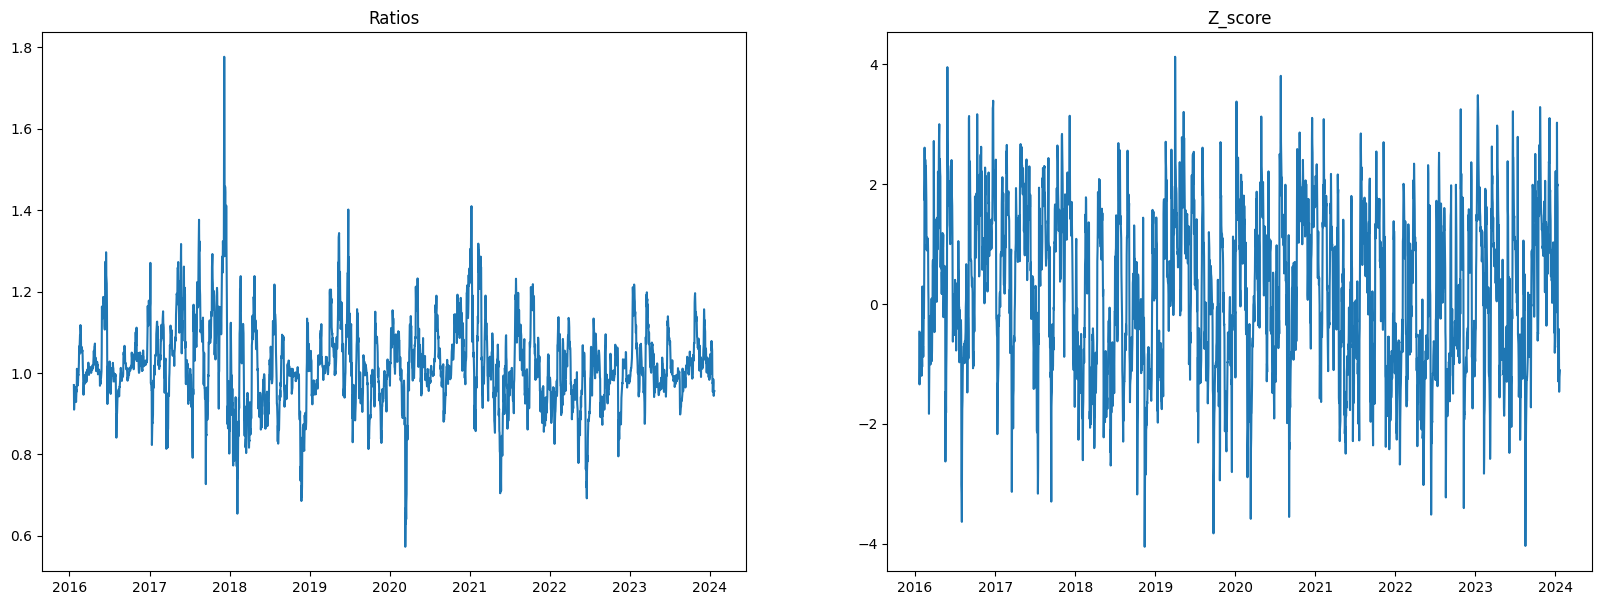

In [40]:
### Plotting z-score and ratios
plt.figure(figsize=(20, 7))

# Placing the plots in the plane 
plot1 = plt.subplot(121)
plot2 = plt.subplot(122)
  
# For Ratios
plot1.plot(df['ratios'].dropna()) 
plot1.set_title("Ratios") 

# For Z_score
plot2.plot(df['z_score'].dropna()) 
plot2.set_title("Z_score") 



#### Percentile values

In [41]:
percentiles = [7,15,85]
z_percentiles = [7,15,93]

ratios = df['ratios'].dropna()
z_score = df['z_score'].dropna()

z_score_percentile_values = np.percentile(z_score,z_percentiles)
percentile_values = np.percentile(ratios,percentiles)

print(f'Percentile values for ratios: {percentile_values}')
print(f'Percentile values for z_score: {z_score_percentile_values}')

Percentile values for ratios: [0.88398558 0.929392   1.11399615]
Percentile values for z_score: [-1.713821   -1.21639177  2.08901826]


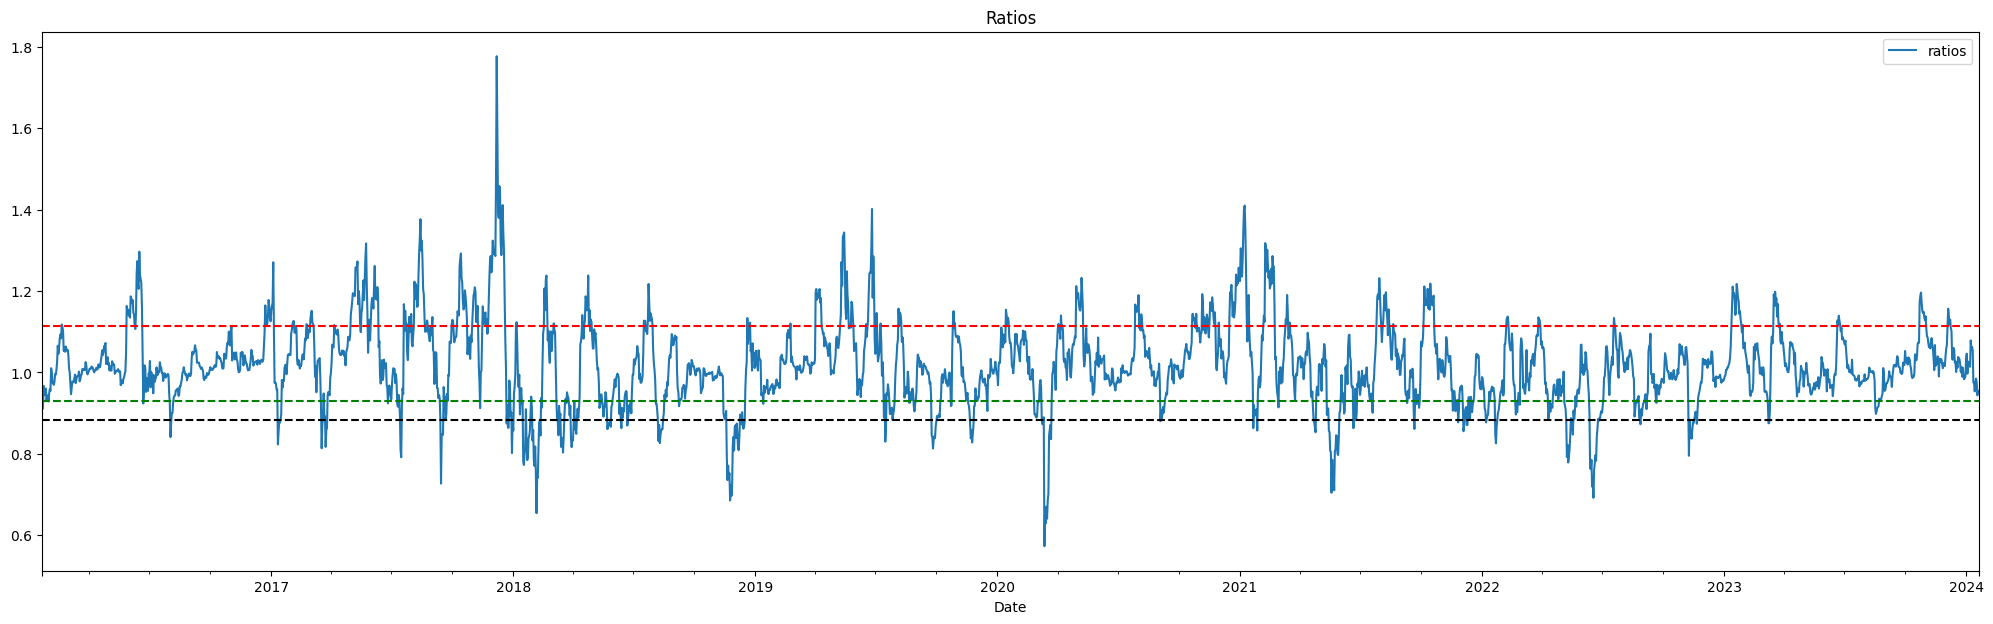

In [42]:
# Adding percentile values to the ratio plot

plt.figure(figsize=(25, 7))
plt.title("Ratios")
df['ratios'].dropna().plot(legend=True)

plt.axhline(percentile_values[0],color='black',linestyle='--',label='7th percentile')
plt.axhline(percentile_values[1],color='green',linestyle='--',label='15th percentile')
plt.axhline(percentile_values[-1],color='red',linestyle='--',label='85th percentile')

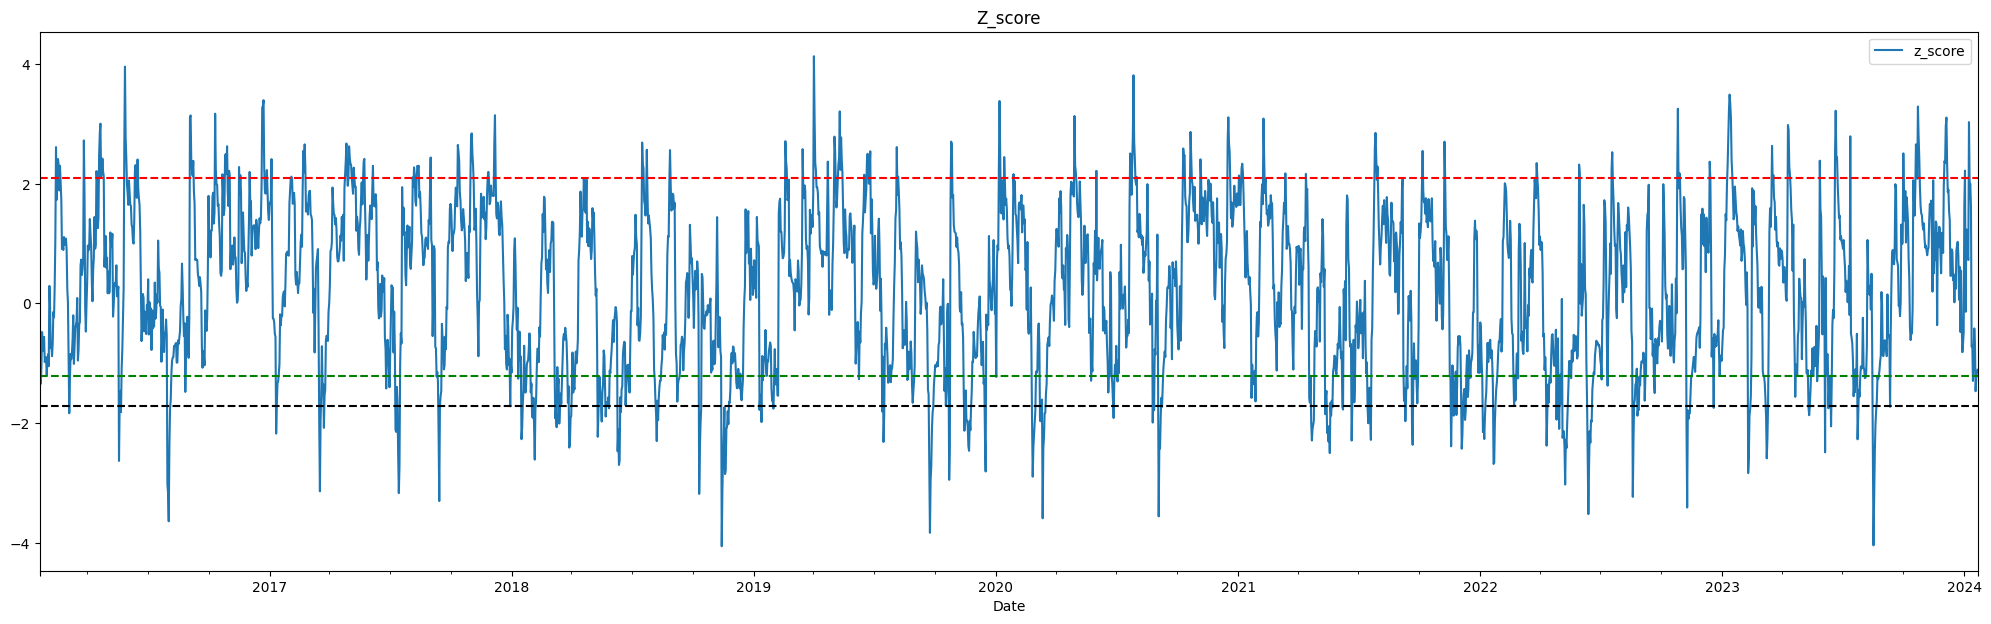

In [43]:
# Adding percentile values to the ratio plot

plt.figure(figsize=(25, 7))
plt.title("Z_score")
df['z_score'].dropna().plot(legend=True)

plt.axhline(z_score_percentile_values[0],color='black',linestyle='--',label='7th percentile')
plt.axhline(z_score_percentile_values[1],color='green',linestyle='--',label='15th percentile')
plt.axhline(z_score_percentile_values[-1],color='red',linestyle='--',label='93 th percentile')

In [103]:
# Looping the DF to calculate days and prices of we buy/sell

position = {
"in":False,
"index":'',
"price":0
}

prices_dates = []


for index,row in df.iterrows():
  if(not position['in'] and row['ratios']<= percentile_values[0] and row['sma_21'] > row['sma_50']):
    prices_dates.append({'index':index,"price":row['Open'],"action":'buy'})
    position['index']=index
    position['in'] = True
    position['price']=row['Open']


  if(position['in'] and row['ratios'] >= percentile_values[-1] and row['sma_21'] <= row['sma_50']):
    prices_dates.append({'index':index,"price":row['Close'],"action":'sell'})
    position['index']=index
    position['in'] = False
    position['price']=0

  
  if(position['in'] and row['Close'] >= position['price']*1.55):
    prices_dates.append({'index':index,"price":row['Close'],"action":'sell'})
    position['index']=index
    position['in'] = False
    position['price']=0

  
  if(position['in'] and row['Close'] <= position['price']*0.75):
    prices_dates.append({'index':index,"price":row['Close'],"action":'sell'})
    position['index']=index
    position['in'] = False
    position['price']=0



In [104]:
# Extracting Buy and Sell Dates and Prices
buy_dates,sell_dates = [],[]
buy_prices,sell_prices=[],[]
for price_date in prices_dates:
  if(price_date['action'] == 'buy'):
    buy_dates.append(price_date['index'])
    buy_prices.append(price_date['price'])
  elif(price_date['action'] == 'sell'):
    sell_dates.append(price_date['index'])
    sell_prices.append(price_date['price'])
  else:
    continue

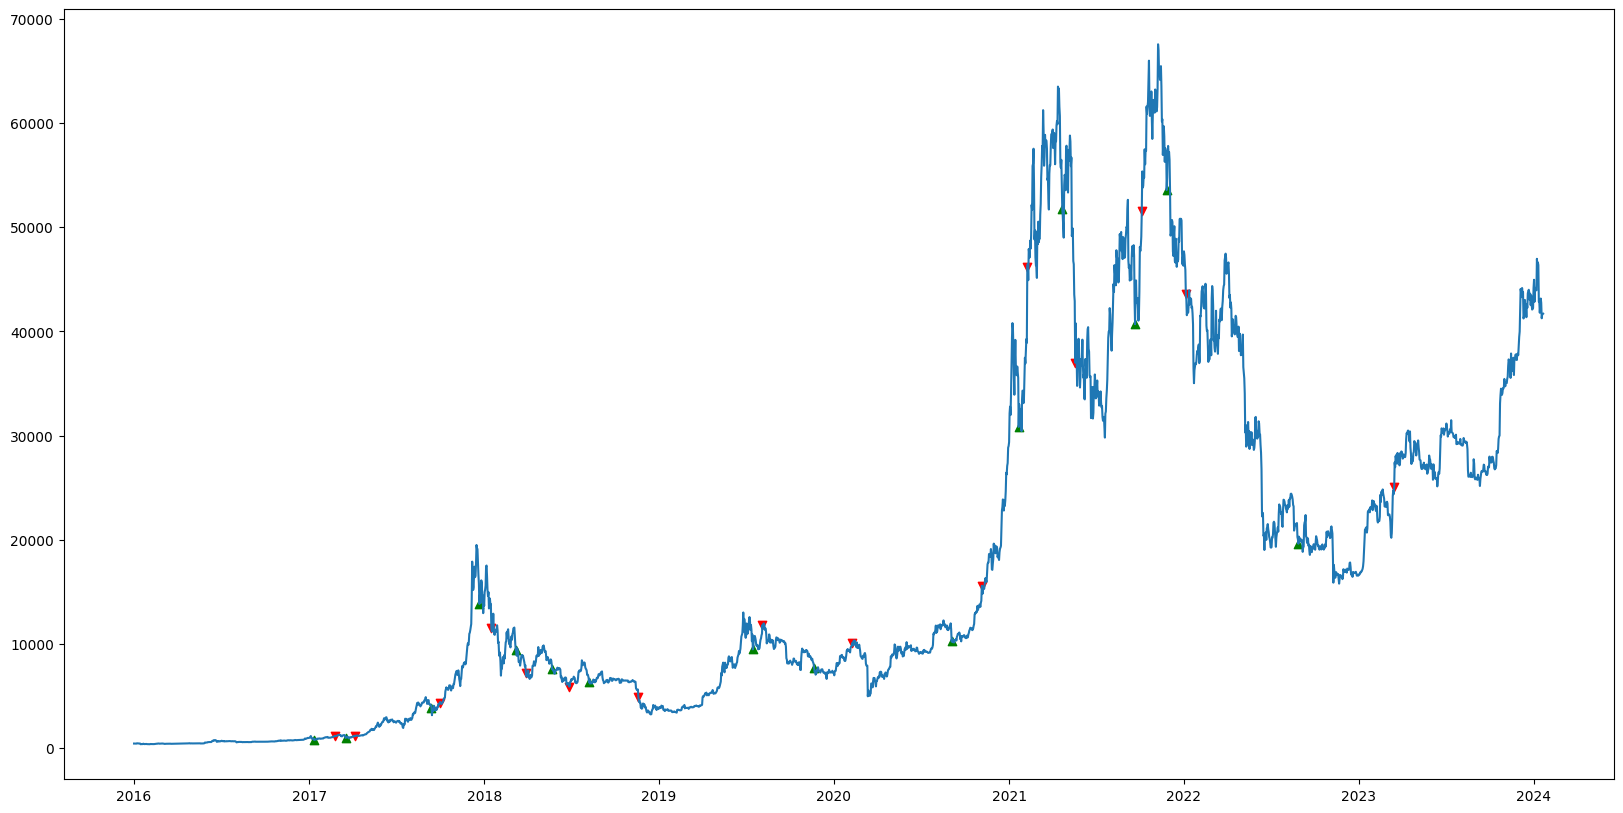

In [105]:
# Plotting
plt.figure(figsize=(20,10))
plt.plot(df['Close'])
plt.scatter(df.loc[buy_dates].index,df.loc[buy_dates].Close,marker='^',c='g')
plt.scatter(df.loc[sell_dates].index,df.loc[sell_dates].Close,marker='v',c='r')

In [106]:
# Calculating Profit

profit = (pd.Series([(sell-buy)/buy for sell,buy in zip(sell_prices,buy_prices)]) + 1).prod() - 1
profit

-0.2619812481026149